# Предиктор результатов футбольных матчей

In [ ]:
#importing
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn # эти строки должны идти перед импортом sklearn
patch_sklearn()                     # для ускорения работы

from sklearn.model_selection    import train_test_split, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics            import accuracy_score, RocCurveDisplay, precision_recall_fscore_support
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import LabelBinarizer
from sklearn.tree               import DecisionTreeClassifier
from sklearn.ensemble           import RandomForestClassifier
from sklearn.inspection         import permutation_importance

from catboost import CatBoostClassifier, Pool, metrics

import shap

from itertools import cycle

from joblib import dump

n_jobs = -1

## Обзор данных

In [2]:
data = pd.read_csv("data.csv")
data.head()

,idmatch,odds_open_win1,odds_open_draw,odds_open_win2,vi_win_home,vi_win_away,vi_nolose_home,vi_nolose_away,vi_over25_home,vi_over25_away,...,team2_away_xgpower_03_draw_xga90index,team2_away_xgpower_03_draw_xgsubxgaindex,team2_away_xgpower_03_cop_xg90index,team2_away_xgpower_03_cop_xga90index,team2_away_xgpower_03_cop_xgsubxgaindex,team2_away_xgpower_03_com_xg90index,team2_away_xgpower_03_com_xga90index,team2_away_xgpower_03_com_xgsubxgaindex,result_finish_match,result_total_match
0,39231,2.53,3.15,3.02,2.255,-4.318,19.259,-3.855,-41.798,-10.410,...,0.98,0.40,2.13,4.88,0.44,0.55,2.79,0.20,2.0,0.0
1,39232,2.16,3.26,3.66,-13.230,-29.496,4.164,-47.122,-43.926,-4.662,...,1.23,0.36,0.00,0.00,0.00,0.51,1.34,0.38,1.0,0.0
2,39233,2.35,3.16,3.31,-35.270,-1.048,-17.721,-2.781,8.467,-6.808,...,0.87,0.31,0.00,0.17,0.00,0.00,0.00,0.00,3.0,1.0
3,39235,2.50,3.25,2.97,17.593,27.970,1.079,10.260,-27.452,-23.279,...,1.99,0.05,0.00,0.00,0.00,0.18,0.80,0.22,3.0,1.0
4,45425,2.15,3.49,3.46,19.656,-22.231,-8.999,-8.685,7.560,-7.321,...,0.64,1.45,3.35,1.40,2.40,0.73,2.48,0.29,1.0,1.0


In [3]:

with open("raw_data_info.txt", mode='w') as df_info:
    data.info(verbose=True, show_counts=True, buf=df_info)
print('\nБаланс классов\n')
print(data['result_finish_match'].value_counts(), '\n')
print(data['result_total_match'].value_counts())



Баланс классов

1.0    24763
3.0    17585
2.0    15099
Name: result_finish_match, dtype: int64 

0.0    29307
1.0    28140
Name: result_total_match, dtype: int64


Классы более или менее сбалансированны.

## Предобработка

Оставим для обучения и теста только данные, удовлетворяющие условию `selection` (см. код ниже).  Nan-строки долой. На тест выделяем 20% данных, остальное -- обучение.

Увеличим обучающий датасет вдвое, продублировав все строки таким образом, чтобы столбцы, отвечающие за одни и те же параметры для разных команд, поменялись местами. У одинаковых матчей одинаковые id, поэтому для кросс-валидации используем GroupKFold, чтобы никакие два матча не попали одновременно в обучающую и валидационную выборки.

In [4]:
# Для решения задачи пригодными считаем лишь данные, для которых коэффициенты "odds_open_tm25" > 1.8 и "odds_open_tb25" > 1.8
selection = (data["odds_open_tm25"] > 1.85) & (data["odds_open_tb25"] > 1.85)

data_selected = data[selection].dropna()
data_selected.shape

(6554, 624)

In [5]:
# Делим на трейн и тест
y_finish = data_selected['result_finish_match'].astype(int) # на это пока не смотрим
y_result = data_selected['result_total_match'].astype(int) 
X = data_selected.drop(['result_finish_match', 'result_total_match'], axis=1)
X.iloc[1:, :].astype('float32', copy=False)

X_train, X_test, y_train, y_test = train_test_split(X, y_result, test_size=0.2, random_state=42, shuffle=True, stratify=y_finish)

In [6]:
# Дублируем данные и переставляем местами пары столбцы следующих видов: 
# "...-2" и "...", 
# "team1..." и "team2...", 
# "...win1" и "...win2" 

def swap(feature_name_1, feature_names_2, train_copy):
    X_train_copy[feature_name_1], X_train_copy[feature_names_2] = X_train_copy[feature_names_2], X_train_copy[feature_name_1]


X_train_copy = X_train.copy(deep=True)
swap('odds_open_win1', 'odds_open_win2', X_train_copy)

for name_2 in X_train_copy.filter(like="-2").columns:  # колонки с паттерном "-2"
    name_1 = ''.join(name_2.split("-2"))  # композиция split и join выделяет из строки подстроку без "-2"
    swap(name_1, name_2, X_train_copy)

for name_2 in X_train_copy.filter(like="team2").columns:  # колонки с паттерном "team2"
    tmp = ''.join(name_2.split("team2"))
    name_1 = 'team1' + tmp  # композиция split и join выделяет из строки подстроку без "team2", слева приписывается "team1"
    swap(name_1, name_2, X_train_copy)


X_train = pd.concat((X_train, X_train_copy))
y_train = pd.concat((y_train, y_train))

In [7]:
groups_train, groups_test = X_train['idmatch'], X_test['idmatch']
X_train.drop('idmatch', axis=1, inplace=True)
X_test.drop('idmatch', axis=1, inplace=True)

X_train.shape, y_train.shape

((10486, 621), (10486,))

In [8]:
# для визуализации результатов сделаем бинаризацию классов: 
# label_binarizer = LabelBinarizer().fit(y_train)
# y_onehot_test = label_binarizer.transform(y_test)
# y_onehot_test.shape  # (n_samples, n_classes)

## Вспомогательные функции

In [9]:
def find_best_model(model, X_train, y_train, groups_train, params_grid, scoring, n_iter=0):
    """
    Функция подбора гиперпараметров
    """

    global n_jobs

    if n_iter:
        search = RandomizedSearchCV(
            model, params_grid, n_iter=n_iter,
            scoring=scoring,
            cv=StratifiedGroupKFold(n_splits=5),
            n_jobs=n_jobs
        )
    else:
        search = GridSearchCV(
        model, params_grid,
        scoring=scoring,
        cv=StratifiedGroupKFold(n_splits=5),
        n_jobs=n_jobs
        )

    search.fit(X_train, y_train, groups=groups_train)

    # Print the best hyperparameters
    print("Best hyperparameters:", search.best_params_)

    # Print the best score
    print("Best cross-val score:", search.best_score_)

    return search.best_estimator_


# def display_roc_curves(probas, auc, target_names):
#     """
#     Отображает микро-усреднённую ROC кривую, а так же ROC-кривые по каждому из классов
#     :probas: предсказанные вероятности классов
#     :auc: Area Under the Curve ROC (macro)
#     :target_names: имена классов
#     """

#     fig, ax = plt.subplots(figsize=(6, 6))

#     fpr_micro, tpr_micro, _ = roc_curve(y_onehot_test.ravel(), probas.ravel())
#     plt.plot(
#         fpr_micro,
#         tpr_micro,
#         label=f"micro-average ROC curve (AUC = {auc:.2f})",
#         color='m',
#         linestyle=":",
#         linewidth=3,
#     )

#     n_classes = probas.shape[1]
#     colors = cycle(["aqua", "darkorange", "cornflowerblue"])
#     for class_id, color in zip(range(n_classes), colors):
#         RocCurveDisplay.from_predictions(
#             y_onehot_test[:, class_id],
#             probas[:, class_id],
#             name=f"ROC curve for {target_names[class_id]}",
#             color=color,
#             ax=ax,
#             plot_chance_level=(class_id == 2),
#         )

#     plt.axis("square")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
#     plt.legend()
#     plt.grid()
#     plt.show()


def test_and_save(estimator, name, X_test, y_test, groups_test):
    """
    Прогоняет обученную модель по тестовой выборке и сохраняет результаты в файл с именем "name_results.csv" 
    в виде таблицы со столбцами: idmatch, истинные классы, предсказания, коэффициенты уверенности (2 столбца), вероятности классов, 
    а также сохраняет саму модель.
    """

    y_pred = np.ravel(estimator.predict(X_test))
    probas = estimator.predict_proba(X_test)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy  = accuracy_score(y_test, y_pred)

    print("Accuracy: ", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:   ", round(recall, 3))
    print("F1:       ", round(f1, 3))

    table = pd.DataFrame({
        'result_finish_match': y_test,
        'result_finish_match_prediction': y_pred,
        'proba_0': probas[:, 0],
        'proba_1': probas[:, 1],
        }, index=groups_test)
    
    # сохраняем таблицу с результатами теста
    table.to_csv(name + '_results.csv')
    
    # сохраняем модель
    dump(estimator, name + '_estimator.joblib')

    # display_roc_curves(probas, roc_auc, ('win_1', 'draw', 'win_2'))

    return table
    

## Логистическая регрессия

In [10]:
log_reg = LogisticRegression(
    penalty='l2',
    solver='newton-cholesky',
    n_jobs=n_jobs
)

params = {"C": np.logspace(-6, 4, 20)}

print("Логистическая регрессия (метрика f1)")
log_reg_best = find_best_model(log_reg, X_train, y_train, groups_train, params, scoring='f1')

Логистическая регрессия (метрика f1)


Best hyperparameters: {'C': 0.18329807108324336}
Best cross-val score: 0.4961749372988475


In [11]:
log_reg_results = test_and_save(log_reg_best, 'logistic_1', X_test, y_test, groups_test)

Accuracy:  0.504
Precision: 0.502
Recall:    0.48
F1:        0.491


invalid value encountered in cast


**Вывод:** рандом

## Решающее дерево

In [12]:
params = {
    'max_depth': range(5, 15, 3),
    'min_samples_split' : range(400, 1001, 20)
}

tree = DecisionTreeClassifier(random_state=42)

print("Решающее дерево (метрика accuracy)")
tree_best = find_best_model(tree, X_train, y_train, groups_train, params, scoring='f1')

Решающее дерево (метрика accuracy)
Best hyperparameters: {'max_depth': 14, 'min_samples_split': 860}
Best cross-val score: 0.48712551032155893


In [13]:
tree_results = test_and_save(tree_best, 'tree_1', X_test, y_test, groups_test)

Accuracy:  0.479
Precision: 0.476
Recall:    0.468
F1:        0.472


invalid value encountered in cast


**Вывод:** хуже чем рандом.

## Случайный лес

In [14]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=n_jobs, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42, warm_start=True)

In [15]:
forest_results = test_and_save(forest, 'forest_1', X_test, y_test, groups_test)

Accuracy:  0.497
Precision: 0.494
Recall:    0.449
F1:        0.471


invalid value encountered in cast


**Вывод:** рандом

Важности признаков в модели случайного леса.

In [16]:
def visualize_feature_importances(model_name, importances_mean, importances_std=None, features=None):

    max = importances_mean.max()

    model_importances = pd.Series(importances_mean, index=features)

    fig, ax = plt.subplots(figsize=(17, 5))
    model_importances.plot.bar(yerr=importances_std, ax=ax)
    ax.set_title(model_name)
    ax.set_ylabel(f"Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

In [17]:
perm_imps_forest = permutation_importance(
    forest, X_test, y_test, n_repeats=5, random_state=43, n_jobs=-1
)

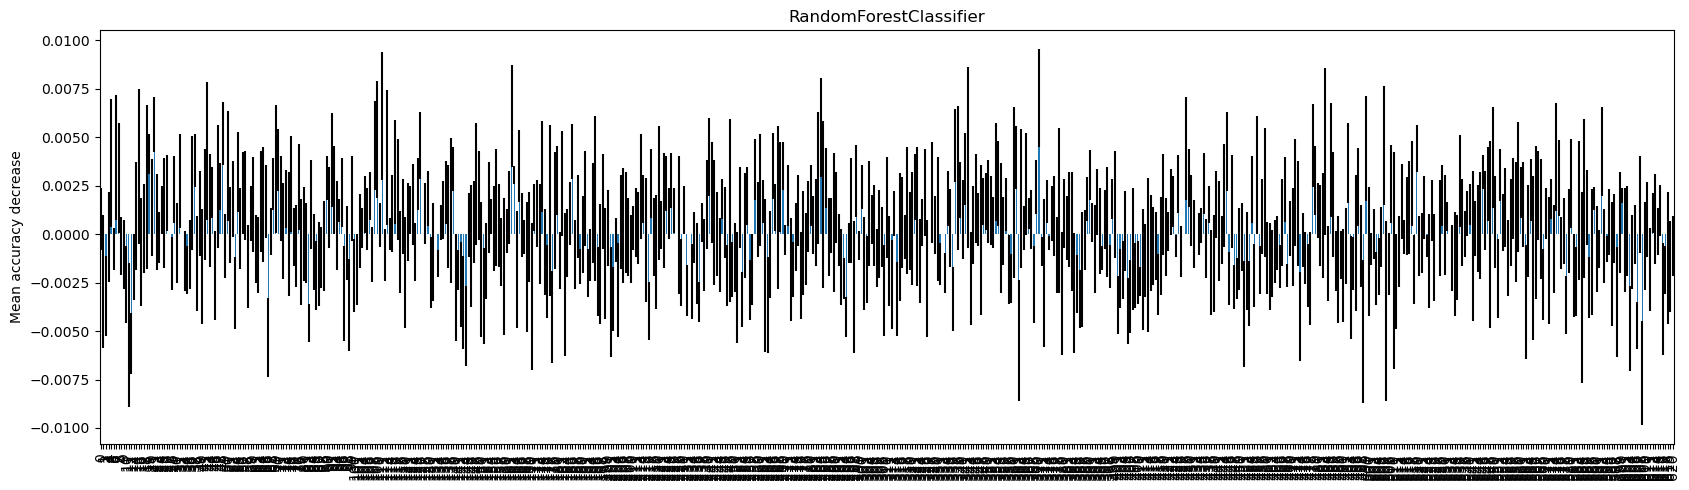

In [18]:
visualize_feature_importances(
    'RandomForestClassifier',
    perm_imps_forest.importances_mean, 
    perm_imps_forest.importances_std
)

Видно, что есть признаки, для которых `mean_accuracy_decrease` отрицательно. Т. е. Удаление этих признаков из датасета может повысить точность. Удалим все, для которых важность не превосходит 0.3 от максимального значения.

In [19]:
good_features = X_test.columns[perm_imps_forest.importances_mean + perm_imps_forest.importances_std > perm_imps_forest.importances_mean.max() * 0.5]

X_test_small, X_train_small = X_test[good_features], X_train[good_features]

X_test_small.shape, X_train_small.shape

((1311, 179), (10486, 179))

In [20]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=n_jobs, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train_small, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42, warm_start=True)

In [21]:
forest_results = test_and_save(forest, 'forest_2', X_test_small, y_test, groups_test)

Accuracy:  0.51
Precision: 0.508
Recall:    0.456
F1:        0.48


invalid value encountered in cast


**Вывод:** ощутимого эффекта нет.

## CatBoost

In [22]:
# создадим пуллы
train_pool = Pool(X_train, y_train)
test_pool  = Pool(X_test,  y_test)

In [23]:
CB_model = CatBoostClassifier(
    iterations=10000,
    loss_function="CrossEntropy",
    use_best_model=True,
    eval_metric=metrics.F1(),
    verbose=250,
    early_stopping_rounds=250
    )

CB_model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.4211137	test: 0.4171889	best: 0.4171889 (0)	total: 193ms	remaining: 32m 14s
250:	learn: 0.7245631	test: 0.4754653	best: 0.4755481 (196)	total: 12.2s	remaining: 7m 52s
500:	learn: 0.8593671	test: 0.4807219	best: 0.4950000 (285)	total: 23.7s	remaining: 7m 30s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.495
bestIteration = 285

Shrink model to first 286 iterations.


In [24]:
CB_results = test_and_save(CB_model, 'catboost', X_test, y_test, groups_test)

Accuracy:  0.538
Precision: 0.542
Recall:    0.456
F1:        0.495


invalid value encountered in cast


**Вывод:** получше, но всё ещё почти рандом.

Посчитаем и выведем в файл `catboost_importances.txt` важности признаков в порядке убывания, а также визуализируем 50 самых "важных".

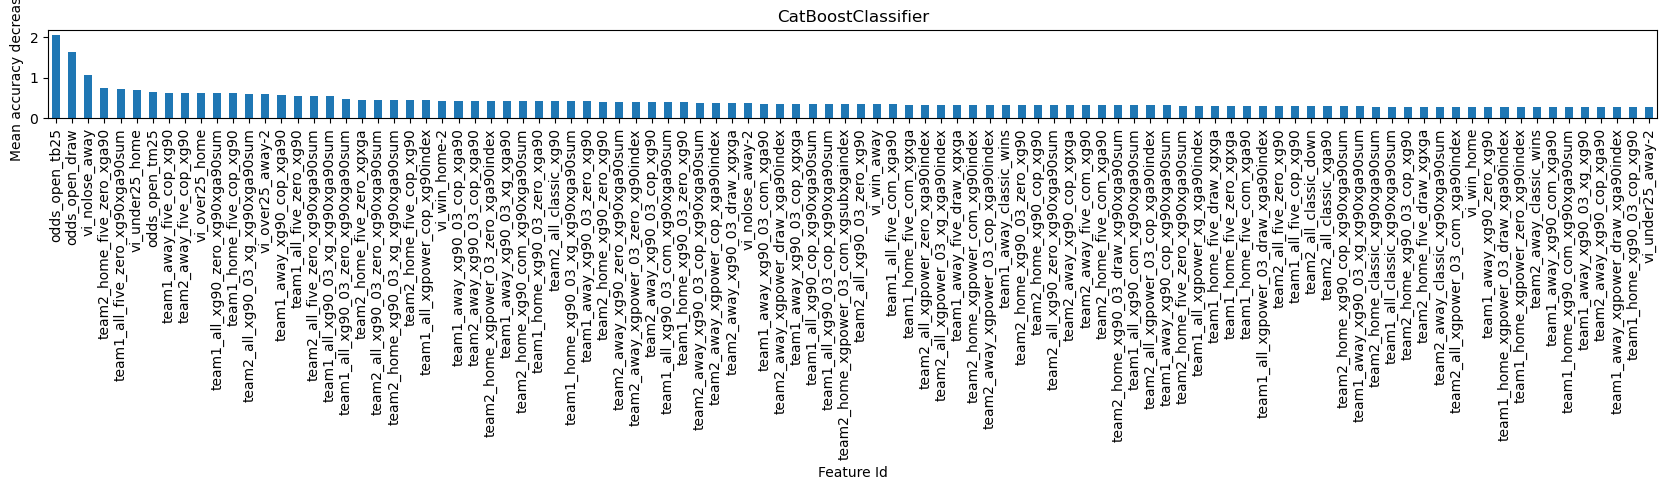

In [25]:
feature_inportances = CB_model.get_feature_importance(train_pool, prettified=True)
feature_inportances.to_csv('catboost_importances.txt')

# сколько признаков визуализировать
n_features_show = 100
# из DataFrame делаем Series
feature_inportances_pdSeries = pd.Series(
    feature_inportances['Importances'].iloc[:n_features_show].values, 
    index=feature_inportances['Feature Id'].iloc[:n_features_show]
    )

visualize_feature_importances(
    'CatBoostClassifier', 
    feature_inportances_pdSeries, 
    features=feature_inportances_pdSeries.index)

**Вывод:** для этого таргета существенно меньше признаков влияют на предсказание. Основной вклад вносят `odds_open_tm25` и `odds_open_tb25`.

Для наглядной интерпретации работы модели может быть полезно применить методы из [этой](https://uproger.com/obyasnite-lyubuyu-model-mashinnogo-obucheniya-na-python-s-pomoshhyu-shap/) статьи. Ниже изображён пример для матча c `id` 32815.

In [26]:
print("Истина:", y_test.iloc[1])
print("Предсказание", CB_model.predict(X_test.iloc[1, :]))
print('"Псевдо-вероятность":', CB_model.predict(X_test.iloc[1, :], prediction_type="RawFormulaVal"))
print("Вероятности:         ", CB_model.predict_proba(X_test.iloc[1, :]))

Истина: 0
Предсказание 1
"Псевдо-вероятность": 0.06134891238920704
Вероятности:          [0.48466758 0.51533242]


In [27]:
explainer = shap.Explainer(CB_model)
shap_values = explainer(X_test)

In [28]:
shap.initjs()
print('Class "win1"')
shap.plots.force(shap_values[1, :])

Class "win1"


**Вывод:** применение этих моделей к реальным данным не представляется целесообразным.